# Project: Traffic Sign Classifier

---
## Load the dataset

In [1]:
# Load pickled data
import pickle
# Custom imports
import os
import random
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import misc
from sklearn.utils import shuffle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Training set
X_train, y_train = train['features'], train['labels']
# Validation set
X_valid, y_valid = valid['features'], valid['labels']
# Test set
X_test, y_test = test['features'], test['labels']

## Train, test and validation set details

The whole dataset includes 51839 different traffic signs in different categories. The dataset is split in training set, validation set and test set. Each traffic sign in the dataset is a 32 x 32 RGB image.

In [2]:
print('X_train: {0}'.format(X_train.shape))
print('y_train: {0}'.format(y_train.shape))
print('X_valid: {0}'.format(X_valid.shape))
print('y_valid: {0}'.format(y_valid.shape))
print('X_test: {0}'.format(X_test.shape))
print('y_test: {0}'.format(y_test.shape))

X_train: (34799, 32, 32, 3)
y_train: (34799,)
X_valid: (4410, 32, 32, 3)
y_valid: (4410,)
X_test: (12630, 32, 32, 3)
y_test: (12630,)


---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic summary of the dataset

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Number of validation examples.
n_valid = X_valid.shape[0]

# Shape of a single traffic sign image
image_shape = '{0} x {1}'.format(X_train.shape[1], X_train.shape[2])

# Number of unique classes/labels in the dataset.
n_classes = len(np.unique(y_train))

print('Number of training examples: {}'.format(n_train))
print('Number of validation examples: {}'.format(n_valid))
print('Number of testing examples: {}'.format(n_test))
print('Image data shape: {}'.format(image_shape))
print('Number of classes: {}'.format(n_classes))

Number of training examples: 34799
Number of validation examples: 4410
Number of testing examples: 12630
Image data shape: 32 x 32
Number of classes: 43


### Exploratory dataset visualization
The following cell shows a set of images randomly selected from the training set.

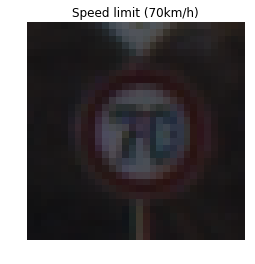

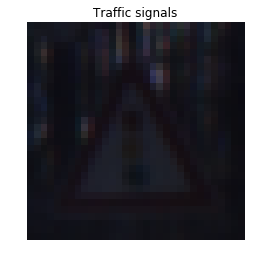

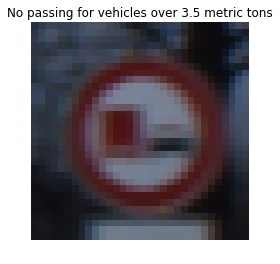

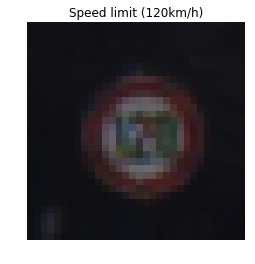

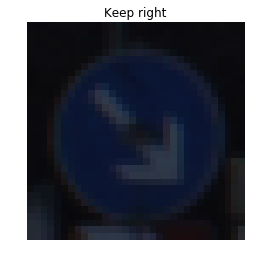

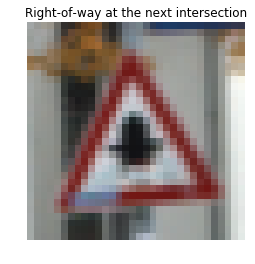

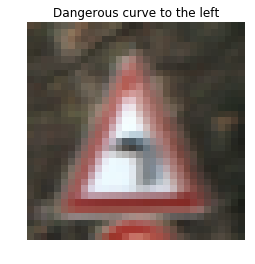

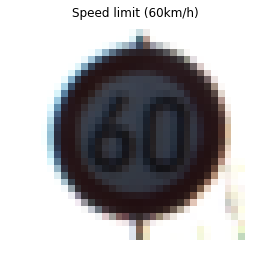

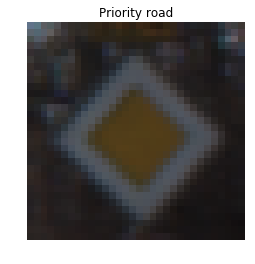

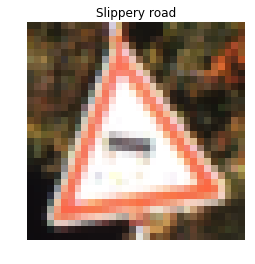

In [4]:
%matplotlib inline

# Load traffic sign ids and labels in a Pandas dataframe
signnames = pd.read_csv('signnames.csv', header=0)
# Assign column names to Pandas dataframe
signnames.columns = ['id', 'label']
# Set the traffic sign id as the index of the dataframe
signnames = signnames.set_index('id')

# Show some saple images
random.seed(42)
for i in range(10):
    image_index = random.randint(1, n_train)
    sign_id = y_train[image_index]
    sign_label = signnames.loc[y_train[image_index]]['label']
    plt.imshow(X_train[image_index])
    plt.title(signnames.loc[sign_id]['label'])
    plt.axis('off')
    plt.show()

## Traffic sign training set frequencies
The dataset is skewed, different traffic signs have different frequencies. As a resut accuracy might not be the best metric for determining the quality of the classifier. This can possibly affect the performances of the classifier for diffeent traffic signs. The expectation is that the classifier is better at classifing traffic signs whose frequecy of samples is higher. Expectation is also that the effectiveness of the traffic sign classifier could, then, be improved for less frequent traffic signs using dataset augmentation techniques including, for instance, rotated images, flipped images, brighter/darker images or images with alternative sources of light.

Traffic sign frequency table

ID	Frequency	Label

2	2010		Speed limit (50km/h)
1	1980		Speed limit (30km/h)
13	1920		Yield
12	1890		Priority road
38	1860		Keep right
10	1800		No passing for vehicles over 3.5 metric tons
4	1770		Speed limit (70km/h)
5	1650		Speed limit (80km/h)
25	1350		Road work
9	1320		No passing
7	1290		Speed limit (100km/h)
3	1260		Speed limit (60km/h)
8	1260		Speed limit (120km/h)
11	1170		Right-of-way at the next intersection
18	1080		General caution
35	1080		Ahead only
17	990		No entry
14	690		Stop
31	690		Wild animals crossing
33	599		Turn right ahead
15	540		No vehicles
26	540		Traffic signals
28	480		Children crossing
23	450		Slippery road
30	390		Beware of ice/snow
6	360		End of speed limit (80km/h)
16	360		Vehicles over 3.5 metric tons prohibited
34	360		Turn left ahead
22	330		Bumpy road
36	330		Go straight or right
20	300		Dangerous curve to the right
40	300		Roundabout mandatory
21	270		Double curve
39	270		Keep left
24	240		Road narrows on the right
29	2

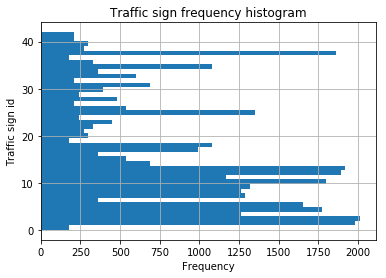

In [5]:
# Show traffic sign training set frequencies
unique, counts = np.unique(y_train, return_counts=True)
sign_freq = dict(zip(unique, counts))
sign_freq = sorted(sign_freq.items(), key=lambda k: k[1], reverse=True)
print("Traffic sign frequency table")
print()
print("ID\tFrequency\tLabel")
print()
for sign_id, sign_label in sign_freq:
    print("{0}\t{1}\t\t{2}".format(sign_id, sign_label, signnames.loc[sign_id]['label']))
print("\n\n")

# Traffic sign training set frequency histogram
plt.hist(y_train, n_classes, orientation='horizontal')
plt.title("Traffic sign frequency histogram")
plt.xlabel("Frequency")
plt.ylabel("Traffic sign id")
plt.grid(True)

----

## Design and Test a Model Architecture

The following cell includes the architecture of a deep learning model representing a traffic sign classifier.
Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Datset pre-processing

The following cell includes some utility functions to use for pre-processing of the dataset. Pre-processing could include normalization, grayscaling, etc...

In [6]:
def normalize(image_data, a=0.1, b=0.9):
    """
    Normalize the image data with Min-Max scaling in range [a, b] (default range [0.1, 0.9])
    :param image_data: The image data to normalize
    :param: a: Normalization lower bound
    :param: b: Normalization upper bound
    :return: Normalized image data
    """
    return a + (image_data - image_data.min()) * (b - a) / (image_data.max() - image_data.min())

def rgb_to_gray_image(rgb_image):
    """
    Convert an image from RGB to grayscale
    :param rgb_image: The RGB image to converto to grayscale
    :return: Grayscale image
    """
    return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    
def rgb_to_gray_images(rgb_images):
    """
    Convert a set of images from RGB to grayscale
    :param: rgb_images: The list of images to convert
    :return: A numpy array of images
    """
    images = []
    for rgb_image in rgb_images:
        images.append(rgb_to_gray_image(rgb_image))
    
    return np.array(images)

def preprocess_image(image):
    """
    Preprocess a single image applying RGB to grayscale conversion and normalization
    :param: image: The image to pre-process
    :return: Pre-processed image
    """
    return normalize(rgb_to_gray_image(image))

def preprocess_images(images):
    """
    Preprocess a set of images
    :param: images: The list of images to pre-process
    :return: A numpy array of pre-processed images
    """
    return normalize(rgb_to_gray_images(images))

# Preprocess the training set (labels don't need pre-processing)
X_train_new = X_train
y_train_new = y_train
X_train_new = preprocess_images(X_train)

# Preprocess the validation set (labels don't need pre-processing)
X_valid_new = X_valid
y_valid_new = y_valid
X_valid_new = preprocess_images(X_valid)

# Preprocess the test set (labels don't need pre-processing)
X_test_new = X_test
y_test_new = y_test
X_test_new = preprocess_images(X_test)

print("X_train_new shape: {0}".format(X_train_new.shape))
print("y_train_new shape: {0}".format(y_train_new.shape))
print("X_valid_new shape: {0}".format(X_valid_new.shape))
print("y_valid_new shape: {0}".format(y_valid_new.shape))
print("X_test_new shape: {0}".format(X_test_new.shape))
print("y_test_new shape: {0}".format(y_test_new.shape))

X_train_new shape: (34799, 32, 32)
y_train_new shape: (34799,)
X_valid_new shape: (4410, 32, 32)
y_valid_new shape: (4410,)
X_test_new shape: (12630, 32, 32)
y_test_new shape: (12630,)


### Replace the original sets with pre-processed sets
Images have been pre-processed applying the following:
1. Conversion from **RGB** to **Grayscale**: apparently colors do not convey useful information for classification. Neurons in different layers detect features like shapes, lines and contrast which are not related to the color itself of the traffic sign. Feeding the network with RGB images, instead of grayscale images, does not bring any improvement to the classification accuracy. Using grayscale images instead of RGB images also simplifies and speeds up the network training due to less amount of data to process.
2. **Normalization** and **feature scaling**: this way gradient descent and similar optimization algorithms converge much faster to the optimal solution. In this scanario Min-Max scaling is used. Each image is scaled in such a way that  values range in the interval [0.1, 0.9].

In [7]:
# Replace original training, validation and test set with preprocessed sets
X_train = X_train_new
y_train = y_train_new
X_valid = X_valid_new
y_valid = y_valid_new
X_test = X_test_new
y_test = y_test_new

# Shuffle the training set to prepare for network trainig
X_train, y_train = shuffle(X_train, y_train)

### Pre-processed image samples

The following cell shows the result of pre-processing applied to some sample images.

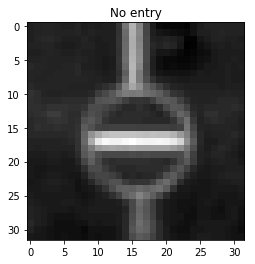

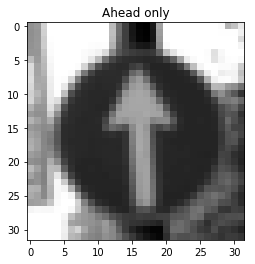

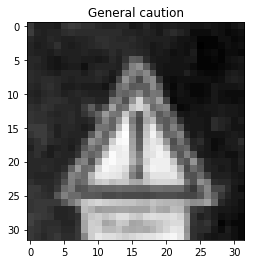

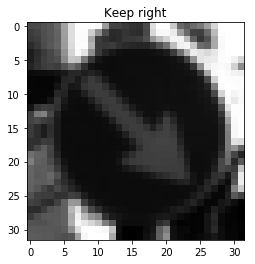

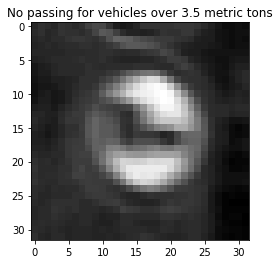

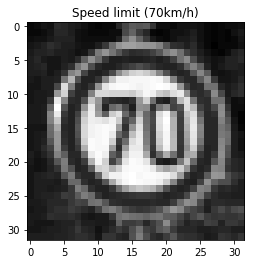

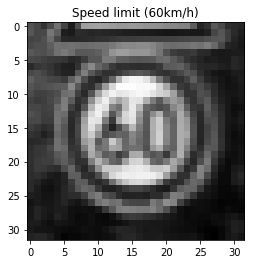

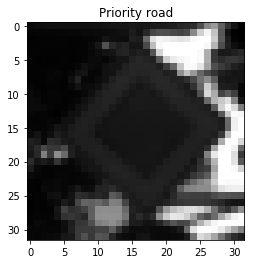

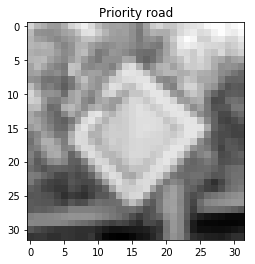

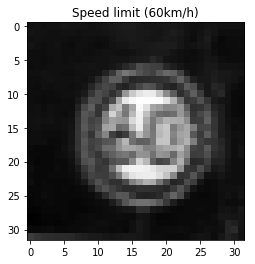

X_train shape: (34799, 32, 32)
y_train shape: (34799,)
X_valid shape: (4410, 32, 32)
y_valid shape: (4410,)
X_test shape: (12630, 32, 32)
y_test shape: (12630,)


In [8]:
# Show some sample pre-processed images
random.seed(42)
for i in range(10):
    index = random.randint(1, n_train)
    plt.imshow(X_train[index], cmap='gray')
    plt.title(signnames.loc[y_train[index]]['label'])
    plt.show()

print("X_train shape: {0}".format(X_train.shape))
print("y_train shape: {0}".format(y_train.shape))
print("X_valid shape: {0}".format(X_valid.shape))
print("y_valid shape: {0}".format(y_valid.shape))
print("X_test shape: {0}".format(X_test.shape))
print("y_test shape: {0}".format(y_test.shape))

### Training, test and validation sets preparation
The Convolutional Neural Network expects 32 x 32 grayscale input images (32 x 32 x 1). As a result the training, validation and test sets are reshaped accordingly.

In [9]:
# Reshape the training, validation and test set so to match the
# input shape required by the model (None, 32, 32, 1)
X_train = X_train.reshape(-1, 32, 32, 1)
X_valid = X_valid.reshape(-1, 32, 32, 1)
X_test = X_test.reshape(-1, 32, 32, 1)

print("X_train shape: {0}".format(X_train.shape))
print("y_train shape: {0}".format(y_train.shape))
print("X_valid shape: {0}".format(X_valid.shape))
print("y_valid shape: {0}".format(y_valid.shape))
print("X_test shape: {0}".format(X_test.shape))
print("y_test shape: {0}".format(y_test.shape))

X_train shape: (34799, 32, 32, 1)
y_train shape: (34799,)
X_valid shape: (4410, 32, 32, 1)
y_valid shape: (4410,)
X_test shape: (12630, 32, 32, 1)
y_test shape: (12630,)


### Model Architecture
The model architecture is made up by the following layers:

1. Convolutional layer + ReLU activation  
   **Input**: 32 x 32 x 1 (H x W x D)  
   **Convolutional filter**: 6 filters, 3 x 3 (H x W), padding = 'VALID', strides = 1,1  
   **Output**: 30 x 30 x 6 (H x W x D)  
   **Parameters**: (3 x 3 x 1 + 1) x 6 = 60 (54 weights and 6 biases)  

2. Convolutional layer + ReLU activation  
   **Input**: 30 x 30 x 6 (H x W x D)  
   **Convolutional filter**: 16 filters, 5 x 5 (H x W), padding = 'VALID', strides = 1,1  
   **Output**: 26 x 26 x 16 (H x W x D)    
   **Parameters**: (5 x 5 x 6 + 1) x 16 = 2416 (2400 weights and 16 biases)  

3. Convolutional layer + ReLU activation + Max pooling  
   **Input**: 26 x 26 x 16 (H x W x D)  
   **Convolutional filter**: 32 filters, 5 x 5 (H x W), padding = 'VALID', strides = 1,1  
   **Output**: 22 x 22 x 32 (H x W x D)  
   **Parameters**: (5 x 5 x 16 + 1) x 32 = 12832 (12800 weights and 32 biases)  
   **Max pooling filter**: 121 filters, 2 x 2 (H x W), padding = 'VALID', strides = 2,2  
   **Output**: 11 x 11 x 32 (H x W x D)  
   **Parameters**: the max pooling layer does not introduce additional parameters  

4. Flattening layer  
   **Input**: 11 x 11 x 32 (H x W x D)  
   **Output**: 1 x 3872 (each input feature map of shape 11 x 11 x 32 is flattened in a single array of 3872 elements)  
   **Parameters**: the flattening layer does not introduce additional parameters, it just reshapes a matrix into an array  

5. Fully connected layer  
   **Input**: 1 x 3872  
   **Output**: 1 x 120  
   **Parameters**: (3872 + 1) x 120 = 464760 (464640 weights and 120 biases)  

6. Dropout layer: inserted to counterbalance the absence of max pooling layers in layers 1 and 2 and to prevent overfitting  
   **Input**: 1 x 3872  
   **Output**: 1 x 120  
   **Parameters**: the dropout layer does not introduce additional parameters. Anyway, the probability of keeping a neuron during training of the network is set to 0.6. The same parameter is set to 1.0 during validation and testing in order to use the full network capability to evaluate the performance of the classifier  

7. Fully connected layer  
   **Input**: 1 x 120  
   **Output**: 1 x 84  
   **Parameters**: (120 + 1) * 84 = 10164 (10080 weights and 84 biases)  

8. Output layer  
   **Input**: 1 x 84  
   **Output**: 1 x 43 (43 different traffic sign classes)  
   **Parameters**: (84 + 1) * 43 = 3655 (3612 weights and 43 biases)  

**Total paremeters**: 493887 (493586 weights and 301 biases)

In [10]:
def weight_variable(shape, mu=0, sigma=0.1):
    """
    Return a normally distributed TensorFlow weight variable
    :param: shape: Weight variable shape
    :param: mu: Weight variable average value
    :param: sigma: Weight variable standard deviation
    :return: Tensor weight variable
    """
    return tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma))

def bias_variable(shape):
    """
    Return a constant TensorFlow bias variable
    :param: shape: Bias variable shape
    :return: Tensor bias variable
    """
    return tf.Variable(tf.constant(0.1, shape=shape))

def conv2d(x, W, strides, padding='VALID'):
    """
    Perform 2D convolution
    :param: x: Input tensor
    :param: W: Weight variable tensor
    :param: strides: Convolution stride
    :param: padding: Image padding ('VALID' or 'SAME')
    :return: Tensor resulting from convolution
    """
    return tf.nn.conv2d(x, W, strides, padding=padding)

def max_pool(x, ksize, strides, padding='VALID'):
    """
    Perform Max Pooling
    :param: x: Input tensor
    :param: ksize: Max pooling filter size
    :param: strides: Max pooling filter stride
    :param: padding: Max pooling filter padding ('VALID' or 'SAME')
    :return: Tensor resulting from convolution
    """
    return tf.nn.max_pool(x, ksize=ksize, strides=strides, padding=padding)

# Input layer: each image is 32 x 32 x 1 (Height x Width x Depth)
x = tf.placeholder(tf.float32, [None, 32, 32, 1], name='x')
y = tf.placeholder(tf.int32, [None], name='y')
# One-hot-encode the labels
y_one_hot = tf.one_hot(y, 43)
# Define keep probability tensor to use with dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

print('x: {0}'.format(x.get_shape()))
print('y: {0}'.format(y.get_shape()))
print('y_one_hot: {0}'.format(y_one_hot.get_shape()))

# Average and standard deviation for weights initialization
mu = 0
sigma = 0.1

# First layer: convolution (no max pooling)
W_conv1 = weight_variable([3, 3, 1, 6], mu, sigma)
b_conv1 = bias_variable([6])
h_conv1 = tf.nn.relu(conv2d(x, W_conv1, strides=[1, 1, 1, 1]) + b_conv1)
print('h_conv1: {0}'.format(h_conv1.get_shape()))

# Second layer: convolution (no max pooling)
W_conv2 = weight_variable([5, 5, 6, 16], mu, sigma)
b_conv2 = bias_variable([16])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, strides=[1, 1, 1, 1]) + b_conv2)
print('h_conv2: {0}'.format(h_conv2.get_shape()))

# Third layer: convolution (no max pooling)
W_conv3 = weight_variable([5, 5, 16, 32], mu, sigma)
b_conv3 = bias_variable([32])
h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, strides=[1, 1, 1, 1]) + b_conv3)
h_pool3 = max_pool(h_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1])
print('h_conv3: {0}'.format(h_conv3.get_shape()))
print('h_pool3: {0}'.format(h_pool3.get_shape()))

# Flatten the Max Pooling layer output to feed the fully connected layer
h_pool3_flat = tf.reshape(h_pool3, [-1, 11 * 11 * 32])
print('h_pool3_flat: {0}'.format(h_pool3_flat.get_shape()))

# First fully connected layer
W_fc1 = weight_variable([11 * 11 * 32, 120])
b_fc1 = bias_variable([120])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
print('h_fc1: {0}'.format(h_fc1.get_shape()))

# Dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
print('h_fc1_drop: {0}'.format(h_fc1_drop.get_shape()))

# Second fully connected layer
W_fc2 = weight_variable([120, 84])
b_fc2 = bias_variable([84])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
print('h_fc2: {0}'.format(h_fc2.get_shape()))

# Output layer
W_out = weight_variable([84, 43])
b_out = bias_variable([43])
y_pred = tf.matmul(h_fc2, W_out) + b_out
print('y_pred: {0}'.format(y_pred.get_shape()))

x: (?, 32, 32, 1)
y: (?,)
y_one_hot: (?, 43)
h_conv1: (?, 30, 30, 6)
h_conv2: (?, 26, 26, 16)
h_conv3: (?, 22, 22, 32)
h_pool3: (?, 11, 11, 32)
h_pool3_flat: (?, 3872)
h_fc1: (?, 120)
h_fc1_drop: (?, 120)
h_fc2: (?, 84)
y_pred: (?, 43)


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets implies **underfitting**. A high accuracy on the training set but low accuracy on the validation set implies **overfitting**. We are interested into finding a set of parameters for the classifier Neural Network which does not overfit or underfit.

In [11]:
def plot_data(train_data_loss, train_data_acc, val_data_loss, val_data_acc, epochs):
    """
    Plot training and validation loss and accuracy
    :param: train_data_loss: Training loss values
    :param: train_data_acc: Training accuracy values
    :param: val_data_loss: Validation loss values
    :param: val_data_acc: Validation accuracy values
    :param: epochs: training and validation epoch values
    """
    # Loss subplot
    fig, _ = plt.subplots()
    train_loss, = plt.plot(epochs, train_data_loss, 'b-', label='Train loss')
    val_loss, = plt.plot(epochs, val_data_loss, 'g-', label='Validation loss')
    plt.legend(handles=[train_loss, val_loss])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation loss')
    fig.tight_layout()
    plt.show()
    
    # Accuracy subplot
    fig, _ = plt.subplots()
    train_acc, = plt.plot(epochs, train_data_acc, 'b-', label='Train accuracy')
    val_acc, = plt.plot(epochs, val_data_acc, 'g-', label='Validation accuracy')
    plt.legend(handles=[train_acc, val_acc])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation accuracy')
    fig.tight_layout()
    plt.show()

### Convolutiona Neural Network training  
Hyperparameters:
1. **Epochs**: 30
2. **Batch size**: 160 samples
3. **Learning rate**: 0.001
4. **Training dropout keep probability**: 0.5

In [12]:
print("X_train shape: {0}".format(X_train.shape))
print("y_train shape: {0}".format(y_train.shape))
print("X_valid shape: {0}".format(X_valid.shape))
print("y_valid shape: {0}".format(y_valid.shape))
print("X_test shape: {0}".format(X_test.shape))
print("y_test shape: {0}".format(y_test.shape))

save_path = "./classifier.ckpt"
if not os.path.isabs(save_path):
    save_path = os.path.abspath(os.path.join(os.getcwd(), save_path))

print("Saving model to {}".format(save_path))
saver = tf.train.Saver()

# Hyperparameters
EPOCHS = 30
BATCH_SIZE = 160
LEARNING_RATE = 0.001

# Dropout keep probabilities to use while training the network
TRAIN_KEEP_PROB = 0.5
# Dropout keep probability must be 1.0 for validation and test set in such a way to use the full network capability
VALID_KEEP_PROB = 1.0
TEST_KEEP_PROB = 1.0

# Loss function to minimize
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_one_hot))
# Single trainign step operation
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss_op)
# Compute number of classes predicted correctly
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_one_hot, 1))
# Compute accuracy of prediction
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def eval_data(features, labels):
    """
    Given a dataset as input returns the loss and accuracy
    :param: features: Dataset features
    :param: labebls: Dataset labels
    :return: Total average loss and total average accuracy
    """
    num_examples = features.shape[0]
    total_acc, total_loss = 0, 0
    session = tf.get_default_session()
    for i in range(0, num_examples, BATCH_SIZE):
        
        batch_x, batch_y = features[i:i + BATCH_SIZE], labels[i:i + BATCH_SIZE]
        loss, acc = session.run([loss_op, accuracy_op],
                             feed_dict={
                                 x: batch_x,
                                 y: batch_y,
                                 keep_prob: VALID_KEEP_PROB
                             })
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples

with tf.Session() as session:
    # Initialize variables
    session.run(tf.global_variables_initializer())
    num_examples = X_train.shape[0]
    print("Start training...")
    print()
    # Collect validation loss data into a list for later graph plot
    training_start_time = time.time()
    # Lists for trainibg and validation loss and accuracy data collection
    val_data_loss = []
    val_data_acc = []
    train_data_loss = []
    train_data_acc = []
    # Train the model
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        for i in range(0, num_examples, BATCH_SIZE):
            # Extract two batches of size BATCH_SIZE for SGD
            batch_x, batch_y = X_train[i:i + BATCH_SIZE], y_train[i:i + BATCH_SIZE]
            _, loss, acc = session.run([train_op, loss_op, accuracy_op],
                               feed_dict={
                                   x: batch_x,
                                   y: batch_y,
                                   keep_prob: TRAIN_KEEP_PROB
                               })

        # Evaluate model on validation set
        val_loss, val_acc = eval_data(X_valid, y_valid)
        # Saving training and validation loss and accuracy data
        train_data_loss.append(loss)
        train_data_acc.append(acc)
        val_data_loss.append(val_loss)
        val_data_acc.append(val_acc)
        epoch_end_time= time.time()
        # Validation loss and accuracy (rate limited)
        if ((epoch + 1) % 10 == 0):
            print("EPOCH {0}, time {1:.1f} sec".format(epoch + 1, epoch_end_time - epoch_start_time))
            print("Validation loss = {:.3f}".format(val_loss))
            print("Validation accuracy = {:.3f}".format(val_acc))
            print()
    
    training_end_time = time.time()
    print("Training time: {0:.1f} sec".format(training_end_time - training_start_time))
    print()
    
    # Save the model
    print("Model saved to {}".format(save_path))
    saver.save(session, save_path)

X_train shape: (34799, 32, 32, 1)
y_train shape: (34799,)
X_valid shape: (4410, 32, 32, 1)
y_valid shape: (4410,)
X_test shape: (12630, 32, 32, 1)
y_test shape: (12630,)
Saving model to C:\Users\Salvatore\Documents\Udacity\SDCND\udacity_carnd\term1\project2_traffic_sign_classifier\classifier.ckpt
Start training...

EPOCH 10, time 17.6 sec
Validation loss = 0.130
Validation accuracy = 0.956

EPOCH 20, time 17.7 sec
Validation loss = 0.100
Validation accuracy = 0.971

EPOCH 30, time 17.6 sec
Validation loss = 0.096
Validation accuracy = 0.976

Training time: 538.6 sec

Model saved to C:\Users\Salvatore\Documents\Udacity\SDCND\udacity_carnd\term1\project2_traffic_sign_classifier\classifier.ckpt


### Plotting training set and validation set loss and accuracy
Plotting the accuracy of the network on both the training set and the validation set allows us to check for overfitting. A network that is overfitting would tipically show good performances on the training set (high accuracy and low loss) and poor performances on the validation set (lower accuracy and higher loss compared to the training set). As a result, we can spot overfitting by looking at the graphs and searching for the epoch when accuracy and loss on the training and validation set start diverging.
In the following graphs we can see that there is no such diverging pattern both in the loss and accuracy. This confirms that the network is not overfitting.

### Train and validation loss and accuracy

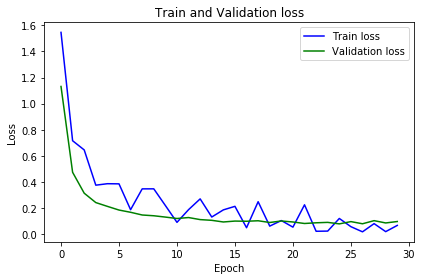

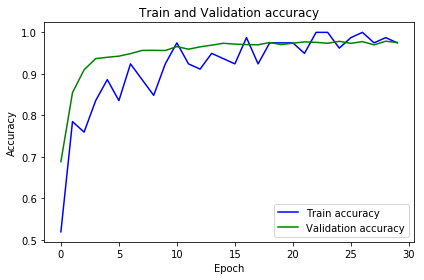

In [13]:
# Plot training and validation loss and accuracy
plot_data(train_data_loss, train_data_acc, val_data_loss, val_data_acc, range(EPOCHS))

### Network accuracy and loss on the test set
Evaluating the performance of the network in classifying images part of the test set, and as such never seen before, we see the classification accuracy is around 96%.

Anyway, overall (average) accuracy is not the only metric to consider when evaluating the performances of a classifier, especially if the training set is skewed as we have seen before. Other metrics to take into account include measuring the **precision**, **recall** and **F1 score** of the classifier for each of the traffic sign classes.

In [14]:
# Evaluate the model on test set
with tf.Session() as session:
    saver.restore(session, save_path)
    # Compute loss and accuracy on test set
    test_start_time = time.time()
    test_loss, test_acc = eval_data(X_test, y_test)
    print("Test loss = {:.3f}".format(test_loss))
    print("Test accuracy = {:.3f}".format(test_acc))
    print()
    test_end_time = time.time()
    print("Test time: {0:.1f} sec".format(test_end_time - test_start_time))
    print()

Test loss = 0.265
Test accuracy = 0.955

Test time: 1.8 sec



### Traffic sign classifier confusion matrix
When it comes to evaluating the performance of a (multiclass) classifier a **confusion matrix** is a good starting point. In this scenario I have used the functionality provided by **scikit-learn** to compute the confusion matrix. Each column of the confusion matrix represents predicted classes (one for each of the possible 43 traffic sign classes) while each row represents actual classes (one for each of the possible 43 traffic sign classes). This results in the confusion matrix being a 43 x 43 matrix. The diagonal elements represent samples for which the classifier predicted label matches the actual label, while off-diagonal elements represent mis-classifications. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions. In this case, since the number of samples varies for different classes, values reported by the confusion matrix have been normalized. Looking at diagonal elements we can see (as expected) that the classifier is better at classifying some traffic signs than others.

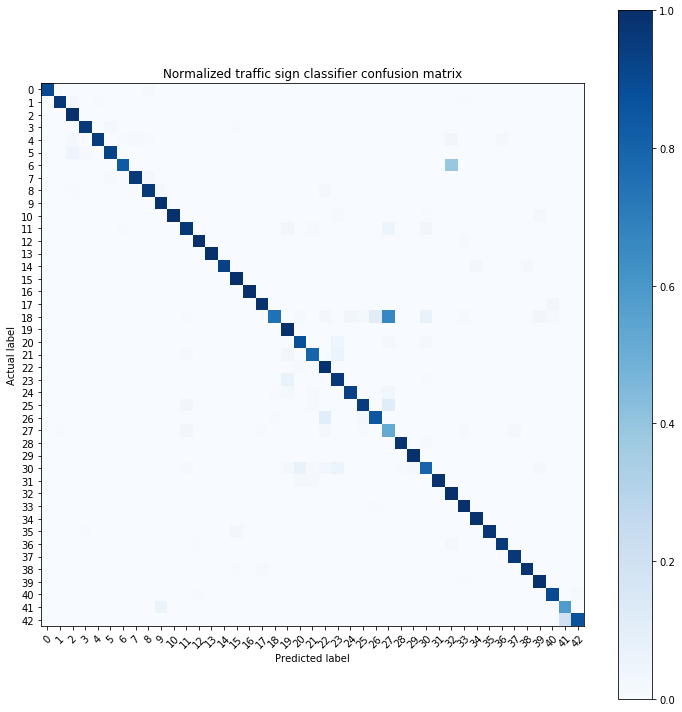

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plot the confusion matrix of a classifier
    Normalization can be applied by setting `normalize=True`
    :param: cm: Confusion matrix
    :param: classes: List of class labels
    :param: normalize: Normalize the confusion matrix (True/False)
    :param: title: Plot title
    :param: cmap: Confusion matrix color map
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

with tf.Session() as session:
    saver.restore(session, save_path)
    # Compute predicted and actual labels using the test set
    pred, actual = session.run((tf.argmax(y_pred, 1), tf.argmax(y_one_hot, 1)), feed_dict={x: X_test, y: y_test, keep_prob: 1.0})
        
    # Plot the normalized confusion matrix using traffic sign IDs as labels
    labels = [i for i in range(0, 43)]
    conf_matrix = confusion_matrix(actual, pred, labels)
    class_names = [i for i in range(0, 43, 1)]
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                      title='Normalized traffic sign classifier confusion matrix')

### Traffic sign classifier precision, recall and F1 score
When evaluating the performance of a multiclass classifier, computing the **precision**, **recall** and **F1 score** of the classifier, for each of che output classes, gives more information about how good the classifier is in classifying each of the different classes.
To be more precise, the **precision** of the classifier is intuitively the ability of the classifier not to label as positive a sample that is negative. So, a high precision value means the classifier has a low number of false positives. The **recall** is intuitively the ability of the classifier to find all the positive samples. So, a high recall value means the classifier has a low number of false negatives. The **F1 score** is a kind of weighted mean of the precision and recall and has its best score at 1 and worst score at 0.

As we can see below, the **precision**, **recall** and **F1 score** of the classifier in classifying different classes varies. This suggestes that using dataset augmentation for some of the traffic sign classes could potentially have benefits on the effectivness of the classifier. This would improve the performances of the classifier for the specific augmented class and its overall performance will improve as a consequence. This also suggests that there is no need to improve the performances of the classifier for some classes. In short, there is no need to apply data augmentation to the training set for the 'Stop' traffic sign, for instance, which has a **F1 score** of 1.00 (applying data augmentation to the 'Stop' traffic sign would likely result in wasting time since the classifier is already good enough to recognize 'Stop' traffic signs).

For instance, the F1 score of the classifier in classifying the 'Pedestrians' traffic sign is lower with respect to others. This suggests that, probably, applying data augmentation to the training set to augment the samples of  'Pedestrians' traffic signs can improve the performance of the classifier in classifying this specific traffic sign and, as a consequence, improve the overall performance of the classifier.

In [16]:
# Compute precision, recall, F1 score and support for each of the 43 traffic sign classes
from sklearn.metrics import precision_recall_fscore_support

def list_to_dict(l):
    d = {}
    for i, v in enumerate(l):
        d[i] = v
    return d

def list_to_table(l, title, reverse=False):
    print("{0} table".format(title))
    print()
    d = list_to_dict(l)
    table = sorted(d.items(), key=lambda k: k[1], reverse=reverse)
    print("ID\t{0}\tLabel".format(title))
    print()
    for i, label in table:
        print("{0}\t{1:.2f}\t\t{2}".format(i, label, signnames.loc[i]['label']))
    print("\n\n")
    return table

precision, recall, fscore, support = precision_recall_fscore_support(actual, pred)
precision_table = list_to_table(precision, "Precision")
recall_table = list_to_table(recall, "Recall  ")
fscore_table = list_to_table(fscore, "F1 score")
support_table = list_to_table(support, "Support  ")

# Select the 3 traffic signs whose F1 score is lower
low_score_ids = []
for score in fscore_table[:3]:
    low_score_ids.append(score[0])
    
# Collect some samples from the test set for which the classifier F1 score is low
# The idea is to feed some of these samples to the network to see what it predicts
low_score_samples = []
for i in range(y_test.shape[0]):
    if y_test[i] in low_score_ids:
        low_score_samples.append(i)
        
print("Low F1 score traffic signs")
print()
print("Id\t\tLabel")
print()
for i in low_score_ids:
    print("{0}\t\t{1}".format(i,signnames.loc[i]['label']))

Precision table

ID	Precision	Label

27	0.37		Pedestrians
32	0.70		End of all speed and passing limits
41	0.74		End of no passing
22	0.84		Bumpy road
30	0.85		Beware of ice/snow
23	0.85		Slippery road
19	0.86		Dangerous curve to the left
26	0.88		Traffic signals
20	0.89		Dangerous curve to the right
11	0.91		Right-of-way at the next intersection
2	0.91		Speed limit (50km/h)
21	0.92		Double curve
39	0.93		Keep left
9	0.93		No passing
40	0.95		Roundabout mandatory
25	0.95		Road work
5	0.96		Speed limit (80km/h)
33	0.96		Turn right ahead
8	0.96		Speed limit (120km/h)
24	0.97		Road narrows on the right
18	0.97		General caution
15	0.97		No vehicles
34	0.98		Turn left ahead
4	0.98		Speed limit (70km/h)
38	0.98		Keep right
3	0.98		Speed limit (60km/h)
29	0.98		Bicycles crossing
17	0.98		No entry
12	0.98		Priority road
1	0.98		Speed limit (30km/h)
36	0.98		Go straight or right
37	0.98		Go straight or left
6	0.98		End of speed limit (80km/h)
7	0.99		Speed limit (100km/h)
42	0.99		End of no pass

### Evaluating the classifier against the classes whose F1 score is lower
In the following cell we evaluate the performance of the classifier in classifying the three traffic signs whose **F1 score** is lower. This gives an understanding of what kind of erros the classifier is experiancing and which traffic sign is taken for what.

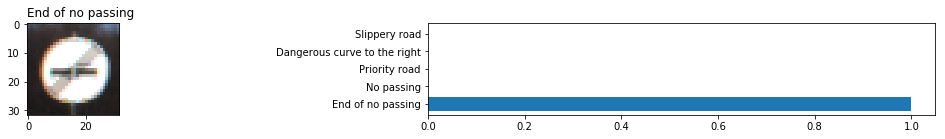

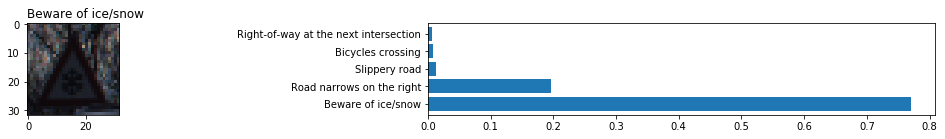

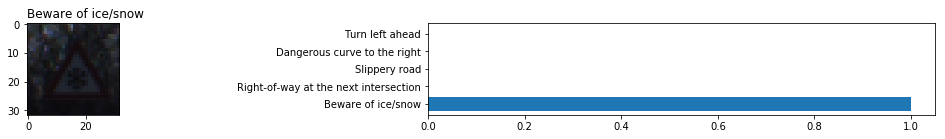

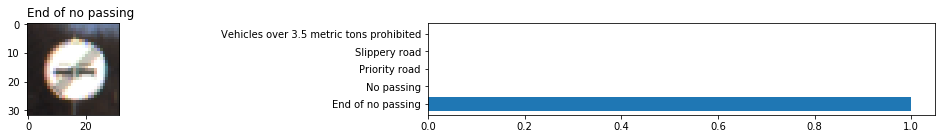

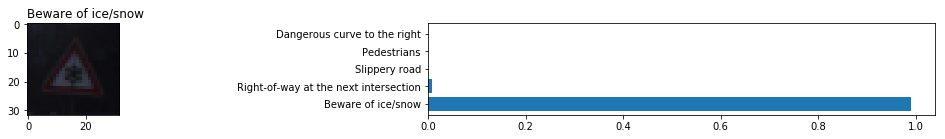

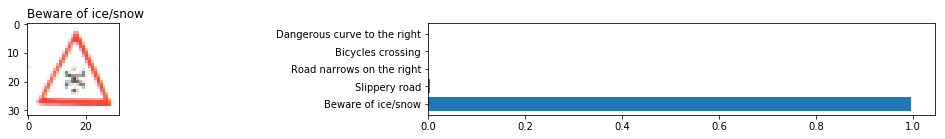

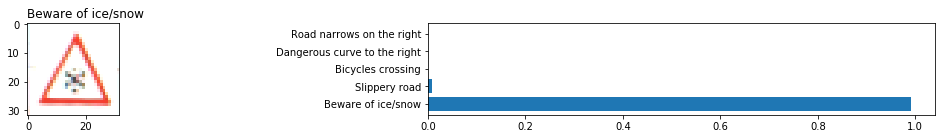

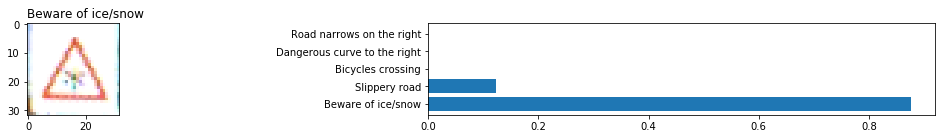

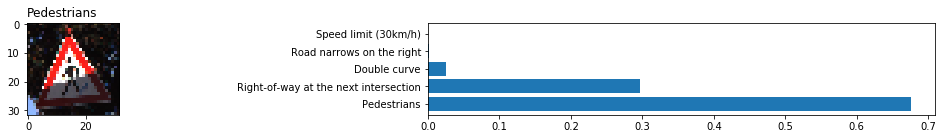

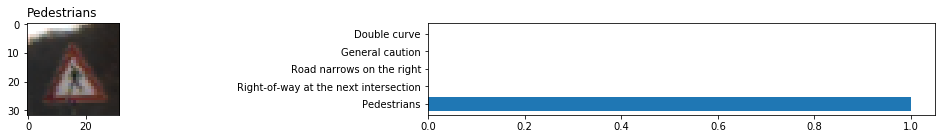

In [17]:
# Open the test set to extract the origina images
with open(testing_file, mode='rb') as f:
    test_set = pickle.load(f)

    test_set_images = test_set['features']
    test_set_labels = test_set['labels']
    
# Select 10 samples from the test set among the images whose classification accuracy is on average lowe
# (see cell output above for a list of traffic signs whose classification accuracy is low)
n_samples = 10
random.seed(31)
# Extract some random samples from the set of traffic signs whose classification accuracy is low
test_samples = random.sample(low_score_samples, n_samples)
# Load images and labels for the random samples
_images = [test_set_images[i] for i in test_samples]
_labels = [test_set_labels[i] for i in test_samples]
# Preprocess the random samples
_gray_images = preprocess_images(_images)
_images = np.array(_images)
_gray_images = np.array(_gray_images).reshape(-1, 32, 32, 1)

with tf.Session() as session:
    saver.restore(session, save_path)
    # Use tf.nn.softmax on network output to compute probabilities and extract 5 top probabilities for each sample
    probabilities = session.run(tf.nn.softmax(y_pred), feed_dict={x: _gray_images, keep_prob : 1.0})
    predicts = session.run(tf.nn.top_k(probabilities, k=5))
    
    # Plot the original images and, for each, the top 5 predicted softmax probabilities
    for i in range(_images.shape[0]):
        plt.figure(figsize=(20, 20))
        plt.subplot(n_samples, 2, 2*i+1)
        plt.title(signnames.loc[_labels[i]]['label'], loc='left')
        plt.imshow(_images[i])
        #plt.axis('off')
        plt.subplot(n_samples, 2, 2*i+2)
        plt.barh(np.arange(0, 5, 1), predicts[0][i])
        y_labels = [signnames.loc[i]['label'] for i in predicts[1][i]]
        plt.yticks(np.arange(0, 5, 1), y_labels)
        plt.show()

        f.close()

---

## Test the model on new images

Here some pictures downloaded from the web are fed to the classifier so to see how the classifier performs on the field.

### Load and Output the Images

Found 6 test images

Original test images


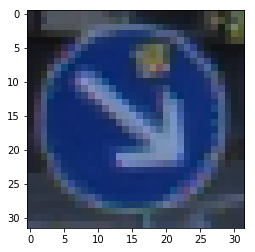

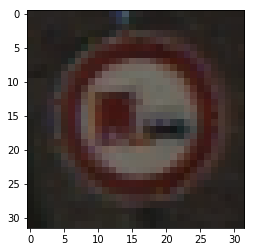

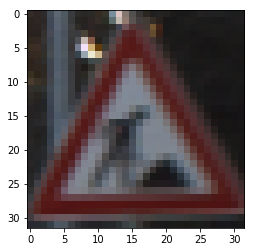

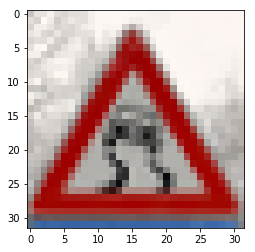

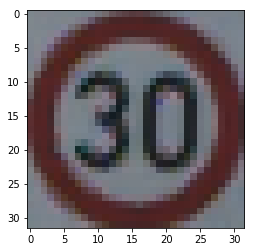

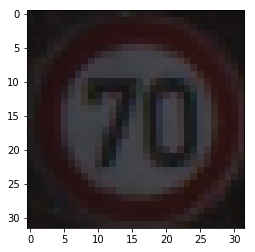

Pre-processed test images


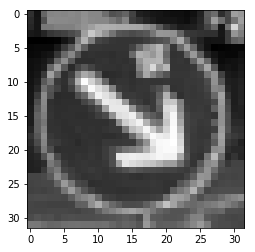

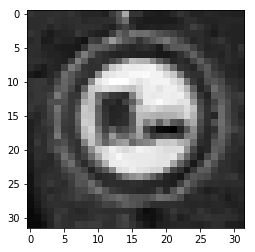

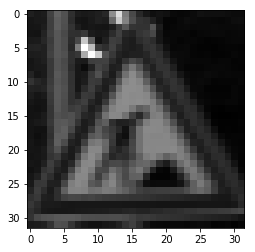

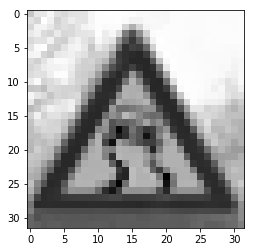

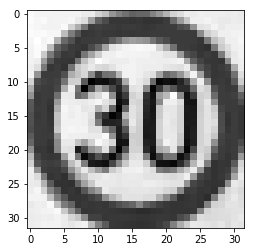

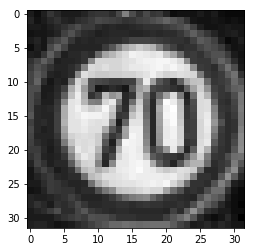

images shape: (6, 32, 32, 3)
gray_images shape: (6, 32, 32, 1)


In [18]:
# Load images to test the model
test_images = os.listdir('test_images/')
n_test_images = len(test_images)
print("Found {} test images".format(n_test_images))
print()

# Load test images as numpy arrays
print("Original test images")
images = []
for img in test_images:
    image_path = os.path.join('test_images', img)
    image = misc.imread(image_path)
    images.append(image)
    plt.imshow(image)
    plt.show()

# Apply preprocessing to test images
print("Pre-processed test images")
gray_images = preprocess_images(images)
for gray_image in gray_images:
    plt.imshow(gray_image, cmap='gray')
    plt.show()

# Convert images to numpy arrays and adjust shapes according to the shape expected by the model
images = np.array(images)
gray_images = np.array(gray_images).reshape(-1, 32, 32, 1)
print("images shape: {}".format(images.shape))
print("gray_images shape: {}".format(gray_images.shape))

### Predict the traffic sign for each image

Run the classifier on the images downloaded from the web.

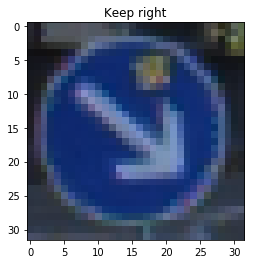

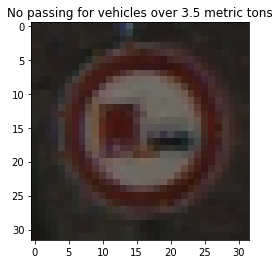

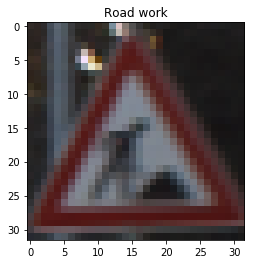

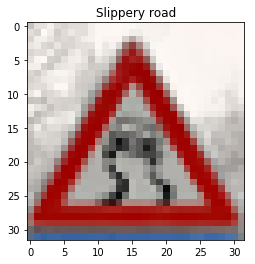

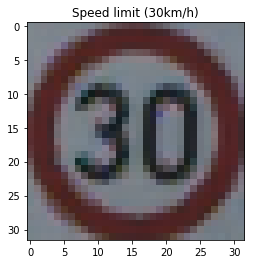

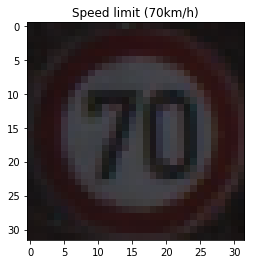

In [19]:
with tf.Session() as session:
    saver.restore(session, save_path)
    # Use tf.nn.softmax on network output to compute probabilities and extract 5 top probabilities for each sample
    probabilities = session.run(tf.nn.softmax(y_pred), feed_dict={x: gray_images, keep_prob : 1.0})
    sign_ids = session.run(tf.argmax(probabilities, axis=1))

# Show predicted labels for the test images
for image, sign_id in zip(images, sign_ids):
    plt.imshow(image)
    plt.title(signnames.loc[sign_id]['label'])
    plt.show()

### Analyze Performance

In [20]:
# Correct test image labels
correct_labels = [38, 10, 25, 23, 1, 4]
if len(correct_labels) != n_test_images:
    print("Only {0} labels for {1} test images".format(len(correct_labels), n_test_images))
# Compute accuracy as the ratio between correctly classified images and total number of images
with tf.Session() as session:
    saver.restore(session, save_path)
    comp_pred = session.run(correct_prediction, feed_dict={x: gray_images, y: correct_labels, keep_prob: 1.0})
    print("Accuracy: {0:.2f}%".format(sum(comp_pred==True) / comp_pred.shape[0] * 100))

Accuracy: 100.00%


### Output the top 5 softmax probabilities for each image found on the web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

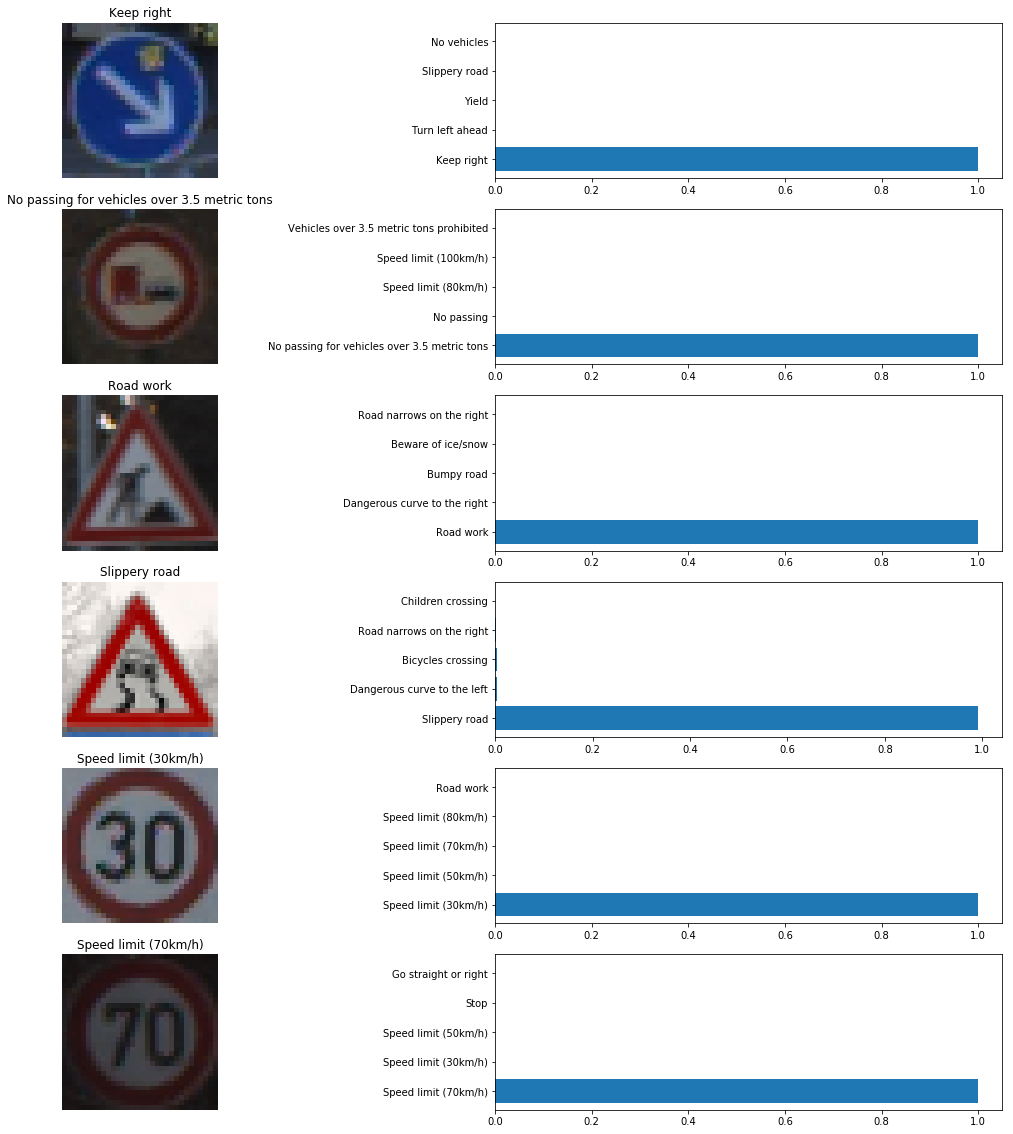

In [21]:
with tf.Session() as session:
    predicts = session.run(tf.nn.top_k(probabilities, k=5))

# Plot the original images and, for each, the top 5 predicted softmax probabilities
plt.figure(figsize=(20, 20))
for i in range(len(predicts[0])):
    plt.subplot(n_test_images, 2, 2*i+1)
    plt.imshow(images[i])
    plt.title(signnames.loc[predicts[1][i][0]]['label'])
    plt.axis('off')
    plt.subplot(n_test_images, 2, 2*i+2)
    plt.barh(np.arange(0, 5, 1), predicts[0][i])
    y_labels = [signnames.loc[i]['label'] for i in predicts[1][i]]
    plt.yticks(np.arange(0, 5, 1), y_labels)
plt.show()

---

## Step 4: Visualize the Neural Network's State with Test Images

While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training the neural network we can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

Provided below is the function code that allows to get the visualization output of any tensorflow weight layer we want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Sample output</p> 
 </figcaption>
</figure>
 <p></p> 

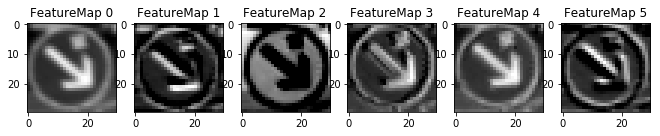

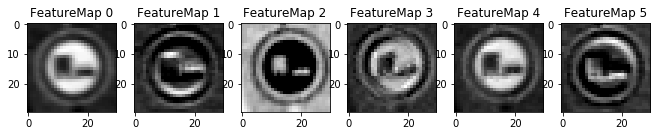

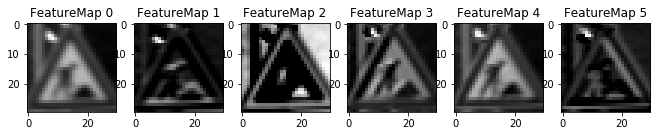

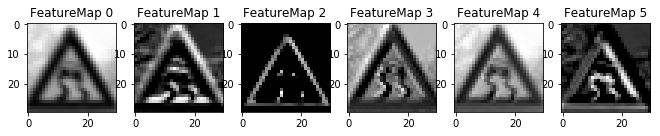

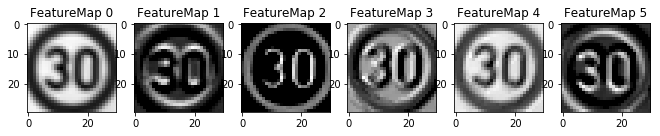

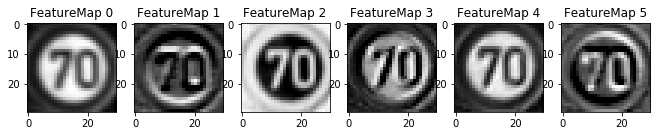

In [22]:
### Visualize your network's feature maps
with tf.Session() as session:
    saver.restore(session, save_path)
    # image_input: the test image being fed into the network to produce the feature maps
    # tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
    # activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
    # plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
    def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
        # Here make sure to preprocess your image_input in a way your network expects
        # with size, normalization, ect if needed
        # image_input =
        # Note: x should be the same name as your network's tensorflow data placeholder variable
        # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
        activation = tf_activation.eval(session=session,feed_dict={x : image_input})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        for featuremap in range(featuremaps):
            plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        
    # First convolutional layer feature maps
    for i in range(gray_images.shape[0]):
        outputFeatureMap([gray_images[i]], tf_activation=h_conv1, plt_num=10+i)
    

### Feature maps

Here I discuss how I used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images.


As we can see from the images above the first convolutional layer feature maps concentrate on identifying different things such as lines in the border of the traffic sign, the shape of lines in the background or the contrast of the image. The interesting thing to note here is that, if RGB images are provided as input to the classifier, apparently, no layer is interested in the color of the traffic sign. This is also the reson why I decided to go on with grayscale images.

Looking at the first feature map labeled as 'FeatureMap 0", for instance, it looks like this set of neurons is looking at the dark parts of the traffic sign. Neurons activate on the borders or on the contens of 'Speed limit', 'Keep right' and 'No passing' since those are darker.

The same happens to other feature maps, each of them identifying different simple features. Moreover in a Convolutional Neural Network as we move towards upper layers from the first layer, neurons activate for increasingly complex shapes and features. The first layer, in this scenario, has neurons activating when detecting simple features such as lines going in different directions, round lines and contrast among different parts of the image. 